## Coarse-Grained Stoichiometry of OXPHOS and Growth reactions
To align the stoichiometries of the reduced HT29 network with the Shestov et al. model, we follow Baroukh et al. (2014) and Tummler et al. (2015) to collapse the elementary flux modes for respiration and biomass formation into two single coarse grained reactions, using pFBA solution as a reference. For growth, we require the reduced model to match the full‐model maximal growth rate on the defined medium at a lactate secretion–to–glucose uptake flux ratio of 1.5.

In [1]:
import cobra

pruned_model = cobra.io.read_sbml_model('../../model/ht29_pruned.xml')
pruned_model.solver = 'gurobi'


Set parameter Username
Academic license - for non-commercial use only - expires 2025-12-28


In [2]:
from cobra.flux_analysis import pfba

# check the default pFBA solution
with pruned_model as m:
    solution = pfba(m)

    summary = m.summary(solution)
    print(summary.to_string(names=True))


Objective
1.0 Generic human cell biomass reaction = 0.06481559423913957

Uptake
------
          Metabolite Reaction      Flux  C-Number C-Flux
           glucose_e MAR09034     2.101         6 85.08%
         linoleate_e MAR09035     0.005        18  0.61%
        linolenate_e MAR09036     0.005        18  0.61%
         histidine_e MAR09038  0.007963         6  0.32%
        isoleucine_e MAR09039   0.01561         6  0.63%
           leucine_e MAR09040   0.03184         6  1.29%
            lysine_e MAR09041   0.02497         6  1.01%
        methionine_e MAR09042  0.007796         5  0.26%
     phenylalanine_e MAR09043    0.0132         9  0.80%
         threonine_e MAR09044   0.01979         4  0.53%
        tryptophan_e MAR09045  0.003422        11  0.25%
            valine_e MAR09046   0.02335         5  0.79%
                O2_e MAR09048   0.04214         0  0.00%
           alanine_e MAR09061   0.04871         3  0.99%
        asparagine_e MAR09062   0.01301         4  0.35%
 

In [3]:
import math
from cobra import Reaction


def build_balancing_reaction(S, flux_vector, rxn_id, model, tol = 1e-10):
    """
    Constructs a single lumped reaction that captures the net effect of all fluxes not explicitly modeled in the reduced network.
    
    Parameters:
    - S: numpy array of shape (m, n), the stoichiometric matrix of the model (m metabolites, n reactions).
    - flux_vector: pandas Series of length n containing optimized fluxes from pFBA.
    - rxn_id: string identifier for the new reaction.
    - model: cobra.Model
    - tol: float threshold; coefficients with absolute value below tol are omitted.
    
    Returns:
    - reaction: cobra.Reaction representing a coarse-grained reaction for the dynamic model, preserving mass and cofactor balances.
    """
 
    result = S.dot(flux_vector)
    metabolites = {}

    for i in range(0, len(result)):
        metabolite = model.metabolites[i]

        if not math.isclose(result[i], 0, abs_tol=tol):
            metabolites[metabolite] = result[i].round(2)

    reaction = Reaction(rxn_id)
    reaction.add_metabolites(metabolites)
    return reaction


In [4]:
from cobra.flux_analysis import pfba
from cobra.util import create_stoichiometric_matrix

# Reactions explicitly retained in the reduced network (from Shestov et al. with additional transport reactions)
protected_reactions = {'MAR09034', 'MAR05029', 'MAR09048', 'MAR04896',
                       'MAR04394', 'MAR04381', 'MAR04379', 'MAR04375',
                       'MAR04391', 'MAR04373', 'MAR04368', 'MAR04365',
                       'MAR04363', 'MAR04358', 'MAR04388', 'MAR05998',
                       'MAR09135', 'MAR03964', 'MAR10024'}

# Compute OXPHOS reaction stoichiometry
with pruned_model as m:
    # Set objective to ATP maintenance reaction
    m.objective = 'MAR03964'
    # Define minimal medium: 
    # MAR09034: Glucose uptake, MAR09048: Oxygen uptake
    m.medium = {'MAR09034': 1, 'MAR09048': 1000}

    solution = pfba(m)
    v = solution.fluxes.copy()
    # Zero out protected reactions
    v[v.index.isin(protected_reactions)] = 0
    # Scale fluxes for consistency with the Shestov model
    v = v / 2

    S = create_stoichiometric_matrix(pruned_model, array_type='dense')
    oxphos = build_balancing_reaction(S, v, 'OXPHOS', m)
    
    print("Oxidative Phosphorylation Reaction:")
    print(oxphos.build_reaction_string(use_metabolite_names=True))

pruned_model.add_reactions([oxphos])
protected_reactions.add('OXPHOS')


Oxidative Phosphorylation Reaction:
14.75 ADP_c + 16.75 H+_c + NADH_c + 3.0 O2_c + 14.75 Pi_c + pyruvate_c --> 14.75 ATP_c + 14.75 H2O_c + NAD+_c


In [5]:
with pruned_model as m:
    solution = pfba(m)

    summary = m.summary(solution)
    print(summary.to_string(names=True))
    

Objective
1.0 Generic human cell biomass reaction = 0.06481559423913957

Uptake
------
          Metabolite Reaction      Flux  C-Number C-Flux
           glucose_e MAR09034     0.347         6 48.50%
         linoleate_e MAR09035     0.005        18  2.10%
        linolenate_e MAR09036     0.005        18  2.10%
         histidine_e MAR09038  0.007963         6  1.11%
        isoleucine_e MAR09039   0.01561         6  2.18%
           leucine_e MAR09040   0.03184         6  4.45%
            lysine_e MAR09041   0.02497         6  3.49%
        methionine_e MAR09042  0.007796         5  0.91%
     phenylalanine_e MAR09043    0.0132         9  2.77%
         threonine_e MAR09044   0.01979         4  1.84%
        tryptophan_e MAR09045  0.003422        11  0.88%
            valine_e MAR09046   0.02335         5  2.72%
                O2_e MAR09048    0.7557         0  0.00%
           alanine_e MAR09061   0.04871         3  3.40%
        asparagine_e MAR09062   0.01301         4  1.21%
 

In [6]:
import numpy as np

# Sweep oxygen uptake bounds to visualize growth and L/G ratio
o2_bounds = np.linspace(-1.0, -0.1, num=10)

growth_rates = []
l_g_ratios = []

for bound in o2_bounds:
    with pruned_model as m:
        m.reactions.MAR09048.bounds = (bound, 0)
        sol = pfba(m)
        mu = sol.fluxes['MAR10024']
        ratio = -sol.fluxes['MAR09135'] / sol.fluxes['MAR09034']
        growth_rates.append(mu)
        l_g_ratios.append(ratio)
    

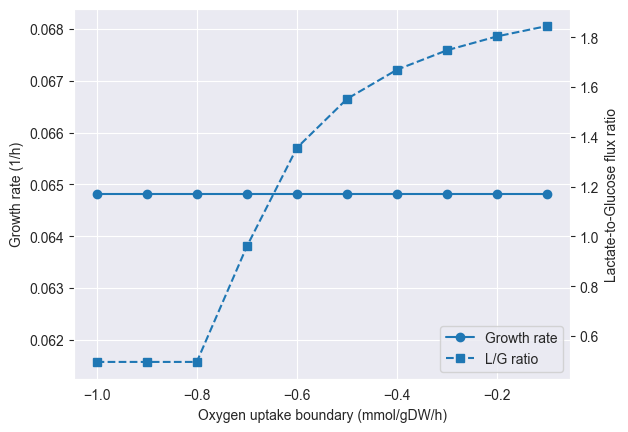

In [7]:
import matplotlib.pyplot as plt

# Plot growth rate and L/G ratio vs oxygen bound on dual axes
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(o2_bounds, growth_rates, marker='o', label='Growth rate')
ax2.plot(o2_bounds, l_g_ratios, marker='s', label='L/G ratio', linestyle='--')

ax1.set_xlabel('Oxygen uptake boundary (mmol/gDW/h)')
ax1.set_ylabel('Growth rate (1/h)')
ax2.set_ylabel('Lactate-to-Glucose flux ratio')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower right')

plt.grid(False)
plt.show()


In [8]:
from cobra.flux_analysis import pfba

# Compute Growth reaction stoichiometry
with pruned_model as m:
    # Constrain oxygen uptake to get L/G flux ratio of 1.5
    m.reactions.MAR09048.bounds = -0.53, 0

    solution = pfba(m)
    ratio = -solution.fluxes['MAR09135'] / solution.fluxes['MAR09034']
    print(f"Lactate-to-Glucose flux ratio: {ratio:.1f}\n")
    
    v = solution.fluxes.copy()
    v[v.index.isin(protected_reactions)] = 0
    v = v * 100 / solution.fluxes['MAR10024']

    S = create_stoichiometric_matrix(m, array_type='dense')
    growth_reaction = build_balancing_reaction(S, v, 'Growth', m)
    
    print("Growth Reaction Stoichiometry:")
    print(growth_reaction.build_reaction_string(use_metabolite_names=True))


Lactate-to-Glucose flux ratio: 1.5

Growth Reaction Stoichiometry:
0.07 1,3-bisphospho-D-glycerate_c + 48.01 3-phospho-D-glycerate_c + 6295.43 ATP_c + 19.53 DHAP_c + 0.43 fructose-1,6-bisphosphate_c + 16.47 fructose-6-phosphate_c + 7.0 GAP_c + 41.29 glucose-6-phosphate_c + 2093.56 H+_e + 6380.63 H2O_c + 289.58 NADH_c + 47.12 O2_c + 241.5 pyruvate_c --> 6295.43 ADP_c + 5716.33 H+_c + 289.58 NAD+_c + 6428.71 Pi_c + 100.0 biomass_e
